In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=d3f293c7fc8444345ece4f5ff0d0eb56b5f6c7e6d423d117783909d45366d395
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import squarify

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
spark = SparkSession.builder.appName('PySpark ML project').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/17 15:21:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sc = spark.sparkContext.getOrCreate()

In [5]:
path = '../input/brain-stroke-dataset/brain_stroke.csv'
df = spark.read.csv(path, header='True', inferSchema='True')
df.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [6]:
df.limit(10).toPandas()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


In [7]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [8]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [9]:
df_pd = df.toPandas()

df_pd.loc[(df_pd.stroke == 1), 'stroke']='Stroke'
df_pd.loc[(df_pd.stroke == 0), 'stroke']='No stroke'

df_pd.loc[(df_pd.heart_disease == 1), 'heart_disease']='Heart disease'
df_pd.loc[(df_pd.heart_disease == 0), 'heart_disease']='No heart disease'

df_pd.loc[(df_pd.hypertension == 1), 'hypertension']='Hypertension'
df_pd.loc[(df_pd.hypertension == 0), 'hypertension']='No hypertension'

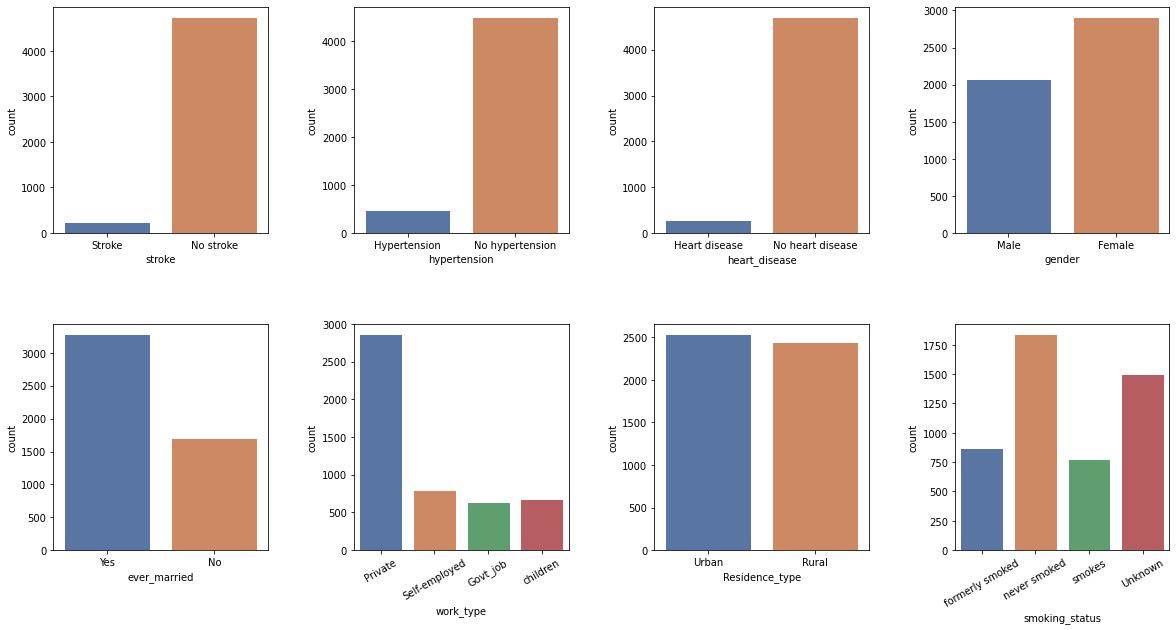

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.set_theme()

sns.countplot(data=df_pd, x='stroke', ax=axes[0,0])

sns.countplot(data=df_pd, x='hypertension', order=['Hypertension', 'No hypertension'], ax=axes[0,1])

sns.countplot(data=df_pd, x='heart_disease', ax=axes[0,2])

sns.countplot(data=df_pd, x='gender', ax=axes[0,3])

sns.countplot(data=df_pd, x='ever_married', ax=axes[1,0])

sns.countplot(data=df_pd, x='work_type', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=30)

sns.countplot(data=df_pd, x='Residence_type', ax=axes[1,2])

sns.countplot(data=df_pd, x='smoking_status', ax=axes[1,3])
axes[1,3].tick_params(axis='x', rotation=30)

<AxesSubplot:title={'center':'BMI distribution'}, xlabel='bmi', ylabel='Count'>

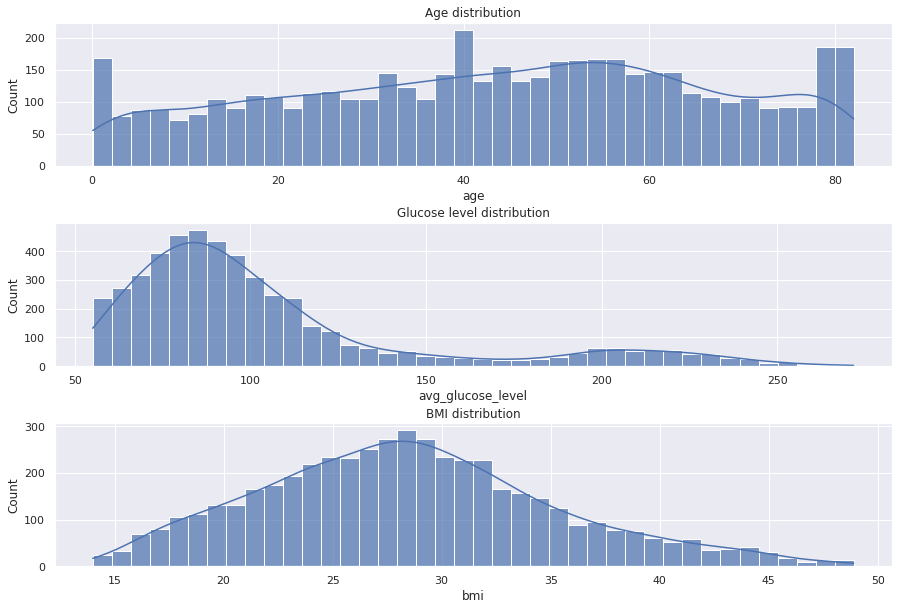

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
sns.set_theme()

axes[0].set_title('Age distribution')
sns.histplot(df_pd['age'], bins=40, kde=True, alpha=0.7, ax=axes[0])

axes[1].set_title('Glucose level distribution')
sns.histplot(df_pd['avg_glucose_level'], bins=40, kde=True, alpha=0.7, ax=axes[1])

axes[2].set_title('BMI distribution')
sns.histplot(df_pd['bmi'], bins=40, kde=True, alpha=0.7, ax=axes[2])

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

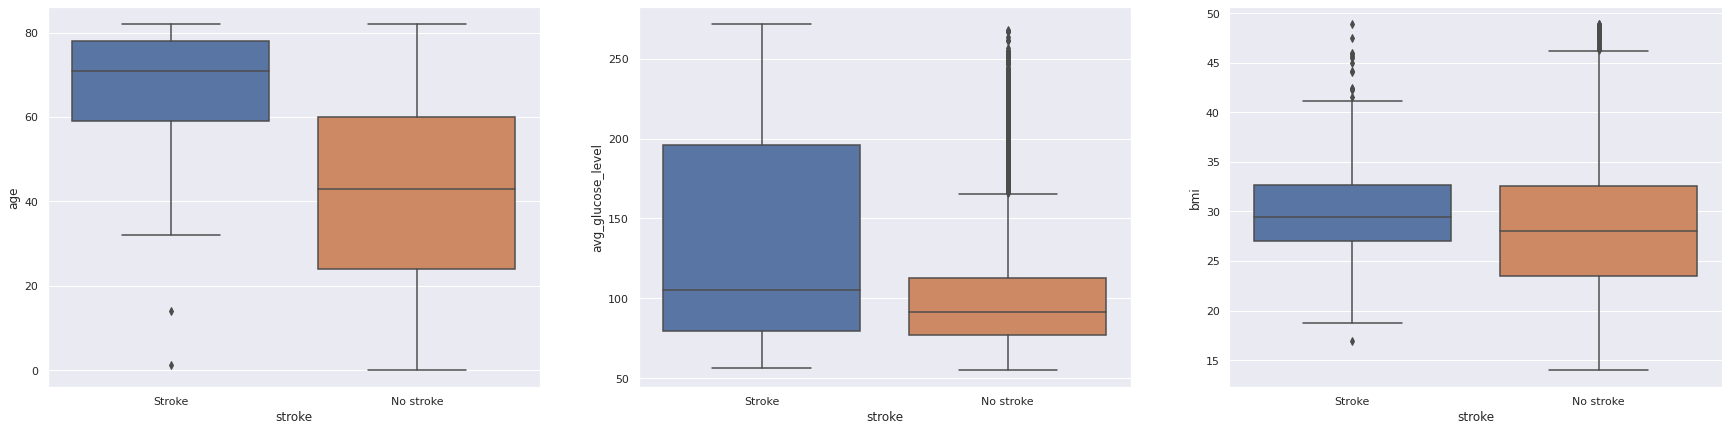

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(30,7))

sns.boxplot(data=df_pd, x='stroke', y='age', ax=axes[0])

sns.boxplot(data=df_pd, x='stroke', y='avg_glucose_level', ax=axes[1])

sns.boxplot(data=df_pd, x='stroke', y='bmi', ax=axes[2])

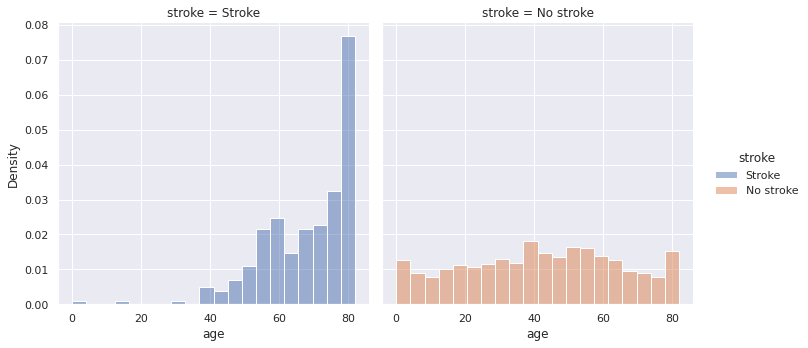

In [13]:
sns.displot(df_pd, x='age', hue='stroke', col='stroke', stat='density', common_norm=False)

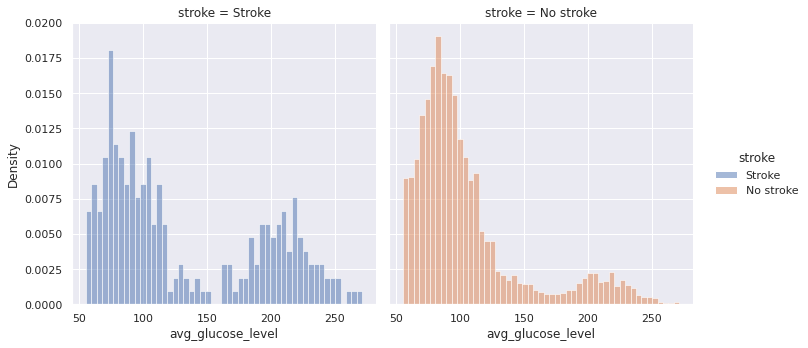

In [14]:
sns.displot(df_pd, x='avg_glucose_level', hue='stroke', col='stroke', stat='density', common_norm=False)

In [15]:
df = df.withColumn(
    'high_risk',
    when((col('age') >= 40) & (col("avg_glucose_level") <= 125), 1).otherwise(0))

df.show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+---------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|high_risk|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+---------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|        0|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|        1|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|        0|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+---------+
only showing top 3 rows



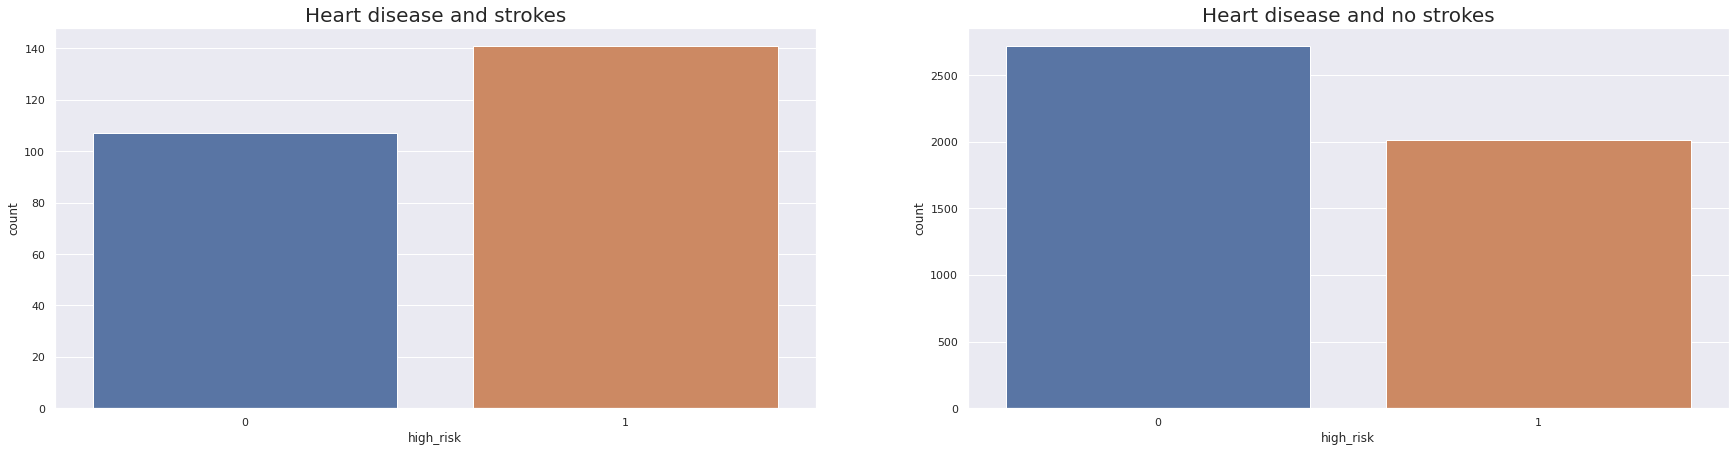

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Heart disease and strokes', fontsize=20)
ax0 = sns.countplot(data=df.toPandas().loc[df_pd['stroke'] == 'Stroke'], x='high_risk', ax=axes[0])

axes[1].set_title('Heart disease and no strokes', fontsize=20)
ax1 = sns.countplot(data=df.toPandas().loc[df_pd['stroke'] == 'No stroke'], x='high_risk', ax=axes[1])

<AxesSubplot:title={'center':'Gender and no strokes'}, xlabel='gender', ylabel='count'>

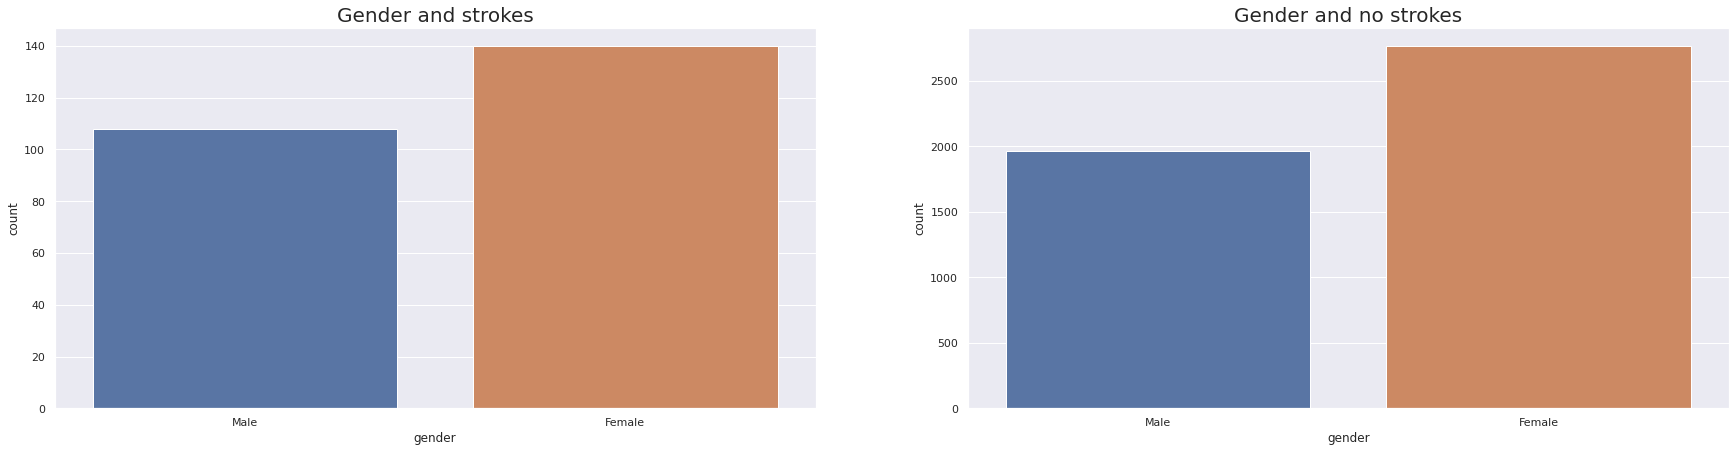

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Gender and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='gender', ax=axes[0])

axes[1].set_title('Gender and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='gender', ax=axes[1])

<AxesSubplot:title={'center':'Hypertension and no strokes'}, xlabel='hypertension', ylabel='count'>

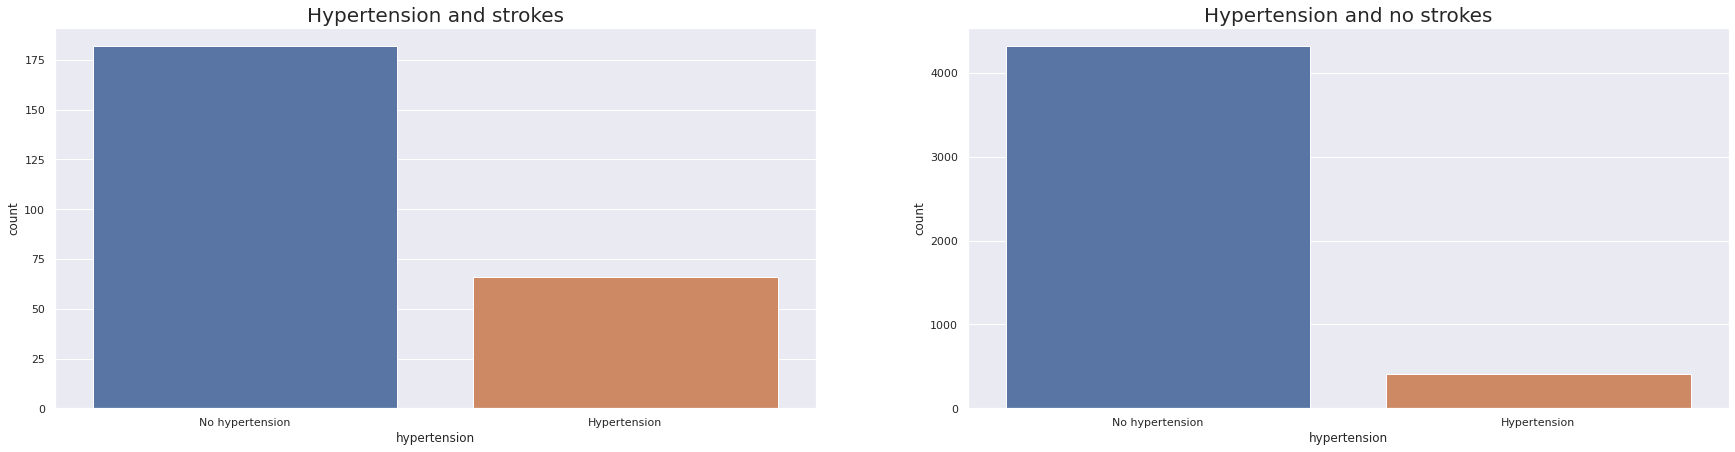

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Hypertension and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='hypertension', ax=axes[0])

axes[1].set_title('Hypertension and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='hypertension', ax=axes[1])

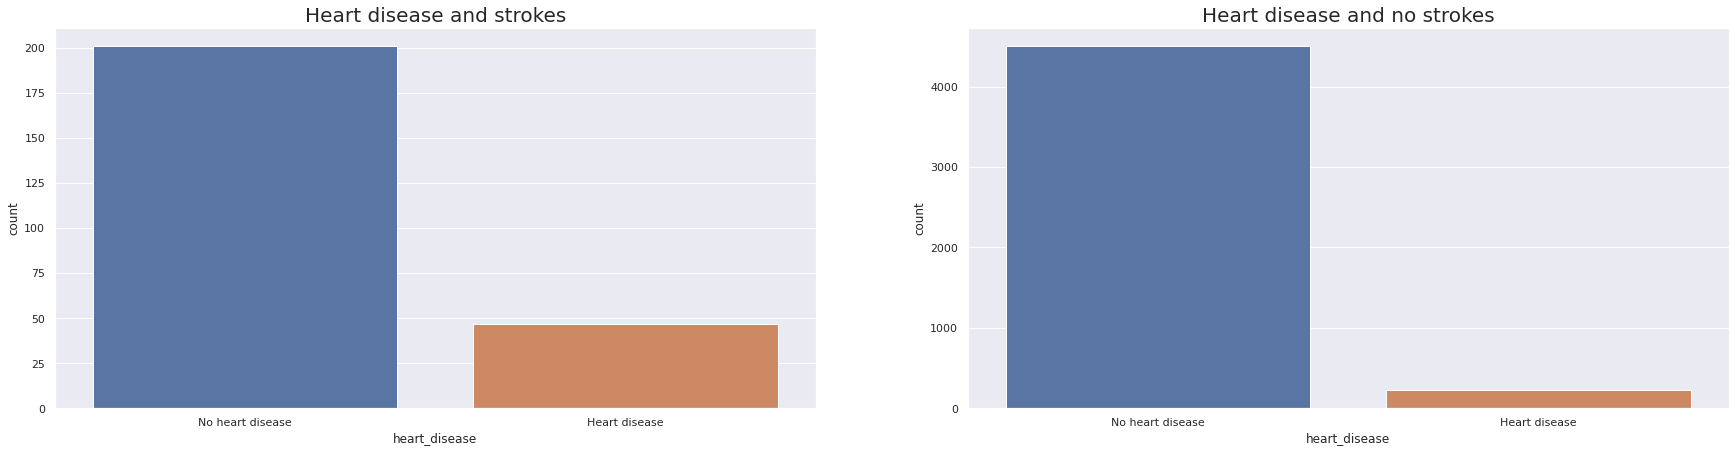

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Heart disease and strokes', fontsize=20)
ax0 = sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='heart_disease', order=['No heart disease', 'Heart disease'], ax=axes[0])

axes[1].set_title('Heart disease and no strokes', fontsize=20)
ax1 = sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='heart_disease', ax=axes[1])

In [20]:
categorical = ('gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status')

In [21]:
indexer = StringIndexer(inputCol='gender', outputCol='gender_vec')
df_indexed = indexer.fit(df).transform(df)

indexer2 = StringIndexer(inputCol='ever_married', outputCol='married_vec')
df_indexed2 = indexer2.fit(df_indexed).transform(df_indexed)

indexer3 = StringIndexer(inputCol='work_type', outputCol='work_vec')
df_indexed3 = indexer3.fit(df_indexed2).transform(df_indexed2)

indexer4 = StringIndexer(inputCol='Residence_type', outputCol='residence_vec')
df_indexed4 = indexer4.fit(df_indexed3).transform(df_indexed3)

indexer5 = StringIndexer(inputCol='smoking_status', outputCol='smoking_vec')
df_indexed5 = indexer5.fit(df_indexed4).transform(df_indexed4)

df = df_indexed5.drop(*categorical)
df.show(3)

+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|high_risk|gender_vec|married_vec|work_vec|residence_vec|smoking_vec|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
|67.0|           0|            1|           228.69|36.6|     1|        0|       1.0|        0.0|     0.0|          0.0|        2.0|
|80.0|           0|            1|           105.92|32.5|     1|        1|       1.0|        0.0|     0.0|          1.0|        0.0|
|49.0|           0|            0|           171.23|34.4|     1|        0|       0.0|        0.0|     0.0|          0.0|        3.0|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
only showing top 3 rows



In [22]:
feature = VectorAssembler(inputCols = df.drop('stroke').columns, outputCol='features')
feature_vector = feature.transform(df)
feature_vector.limit(3).toPandas()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,high_risk,gender_vec,married_vec,work_vec,residence_vec,smoking_vec,features
0,67.0,0,1,228.69,36.6,1,0,1.0,0.0,0.0,0.0,2.0,"(67.0, 0.0, 1.0, 228.69, 36.6, 0.0, 1.0, 0.0, ..."
1,80.0,0,1,105.92,32.5,1,1,1.0,0.0,0.0,1.0,0.0,"[80.0, 0.0, 1.0, 105.92, 32.5, 1.0, 1.0, 0.0, ..."
2,49.0,0,0,171.23,34.4,1,0,0.0,0.0,0.0,0.0,3.0,"(49.0, 0.0, 0.0, 171.23, 34.4, 0.0, 0.0, 0.0, ..."


In [23]:
ml_df = feature_vector.select(['features', 'stroke'])
train, test = ml_df.randomSplit([0.8, 0.2])

In [24]:
lr = LogisticRegression(labelCol='stroke')

paramGrid = ParamGridBuilder().addGrid(lr. regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25, 0.75))\
                              .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

lr_model = tvs.fit(train)
lr_model_pred = lr_model.transform(test)

In [25]:
results = lr_model_pred.select(['probability', 'stroke'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print('Accuracy:  ', round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(lr_model_pred), 4))
print('Precision: ', round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(lr_model_pred), 4))
print('ROC Score: ', round(metrics.areaUnderROC, 4))

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


Accuracy:   0.9485
Precision:  0.8996
ROC Score:  0.8423


In [26]:
rf = RandomForestClassifier(labelCol='stroke')

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 20])\
                              .addGrid(rf.maxBins, [20, 32, 50])\
                              .addGrid(rf.numTrees, [20, 40, 60])\
                              .addGrid(rf.impurity, ['gini', 'entropy'])\
                              .addGrid(rf.minInstancesPerNode, [1, 5, 10])\
                              .build()
    
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

rf_model = tvs.fit(train)
rf_model_pred = rf_model.transform(test)

22/08/17 15:23:55 WARN DAGScheduler: Broadcasting large task binary with size 1092.9 KiB
22/08/17 15:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1356.3 KiB
22/08/17 15:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1062.1 KiB
22/08/17 15:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1130.4 KiB
22/08/17 15:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1150.1 KiB
22/08/17 15:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1546.7 KiB
22/08/17 15:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1953.3 KiB
22/08/17 15:24:10 WARN DAGScheduler: Broadcasting large task binary with size 1277.1 KiB
22/08/17 15:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1030.4 KiB
22/08/17 15:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1291.9 KiB
22/08/17 15:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1524.1 KiB
22/08/17 15:24:15 WAR

In [27]:
results = rf_model_pred.select(['probability', 'stroke'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print('Accuracy:  ', round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(rf_model_pred), 4))
print('Precision: ', round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(rf_model_pred), 4))
print('ROC Score: ', round(metrics.areaUnderROC, 4))

Accuracy:   0.9455
Precision:  0.8995
ROC Score:  0.8095
